# Linear regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn 

## Loading the data

In [2]:
url= "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%202/data/FuelConsumptionCo2.csv"
df=pd.read_csv(url)
df = df.rename(columns={'FUELCONSUMPTION_CITY':'FLCON_CITY','FUELCONSUMPTION_HWY':'FLCON_HWY','FUELCONSUMPTION_COMB': 'FLCON_COMB', 'FUELCONSUMPTION_COMB_MPG': 'FLCON_COMB_MPG'})

## Description of Dataset

This dataset contains variables describing technical specifications and environmental performance metrics of automobiles. The focus is on engine characteristics, fuel consumption, and carbon emissions.

- **MODELYEAR**: Year the car model was released (e.g., 2014)
- **ENGINESIZE**: Engine displacement in litres (e.g., 3.0)
- **CYLINDERS**: Number of engine cylinders (e.g., 6)
- **FLCON_CITY**: Fuel consumption in urban driving conditions (L/100 km) (e.g., 13.2)
- **FLCON_HWY**: Fuel consumption on highways (L/100 km) (e.g., 9.5)
- **FLCON_COMB**: Combined fuel consumption (city and highway) (L/100 km) (e.g., 11.5)
- **FLCON_COMB_MPG**: Combined fuel consumption in miles per gallon (e.g., 25)
- **CO2EMISSIONS**: Carbon dioxide emissions per kilometre (g/km) (e.g., 182)

We would like to model the relationships between variables. This will be done through simple linear regression and we will focus on what the relationship between FLCON_CITY and some other variables is.

## Exploratory data analysis


In [3]:
df.describe()

,MODELYEAR,ENGINESIZE,CYLINDERS,FLCON_CITY,FLCON_HWY,FLCON_COMB,FLCON_COMB_MPG,CO2EMISSIONS
count,1067.0,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000
mean,2014.0,3.346298,5.794752,13.296532,9.474602,11.580881,26.441425,256.228679
std,0.0,1.415895,1.797447,4.101253,2.794510,3.485595,7.468702,63.372304
min,2014.0,1.000000,3.000000,4.600000,4.900000,4.700000,11.000000,108.000000
25%,2014.0,2.000000,4.000000,10.250000,7.500000,9.000000,21.000000,207.000000
50%,2014.0,3.400000,6.000000,12.600000,8.800000,10.900000,26.000000,251.000000
75%,2014.0,4.300000,8.000000,15.550000,10.850000,13.350000,31.000000,294.000000
max,2014.0,8.400000,12.000000,30.200000,20.500000,25.800000,60.000000,488.000000


The histograms show the distribution of selected continuous features. Notably, `FLCON_CITY`, `FLCON_HWY`, and `FLCON_COMB` are tightly clustered and approximately normally distributed, with a modest right skew. Their resemblance suggests they measure related phenomena (urban, highway, and combined fuel consumption), reinforcing our expectation of strong correlations.

On the other hand, `FLCON_COMB_MPG` is inversely related to the L/100 km variables and skews oppositely, as expected due to the inverse relationship between MPG and L/100 km.

These observations guide our feature selection: we choose variables whose distributions align well and are likely to yield interpretable linear relationships.


array([[<Axes: title={'center': 'MODELYEAR'}>,
        <Axes: title={'center': 'ENGINESIZE'}>,
        <Axes: title={'center': 'CYLINDERS'}>,
        <Axes: title={'center': 'FLCON_CITY'}>],
       [<Axes: title={'center': 'FLCON_HWY'}>,
        <Axes: title={'center': 'FLCON_COMB'}>,
        <Axes: title={'center': 'FLCON_COMB_MPG'}>,
        <Axes: title={'center': 'CO2EMISSIONS'}>]], dtype=object)

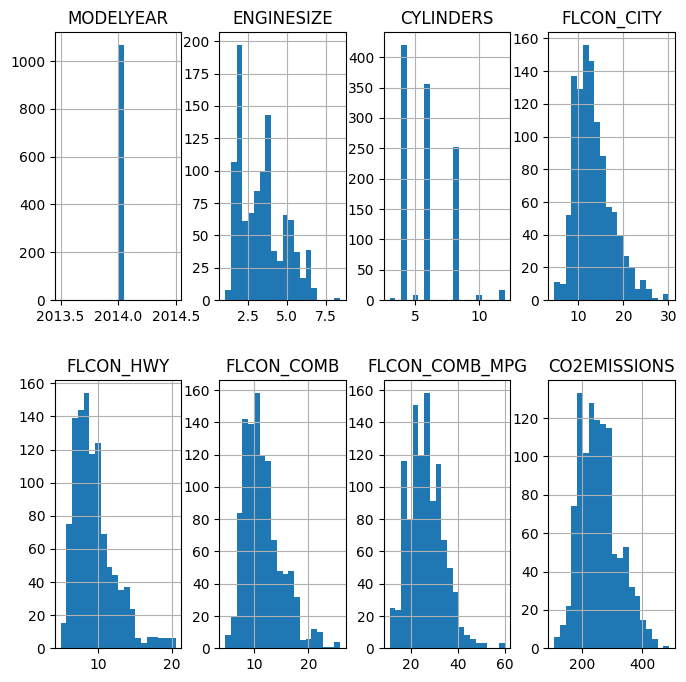

In [4]:
df.hist(figsize=(8,8),layout=(2,4),bins=20)

The histograms show the distribution of selected continuous features. Notably, `FLCON_CITY`, `FLCON_HWY`, and `FLCON_COMB` are tightly clustered and approximately normally distributed, with a modest right skew. Their resemblance suggests they measure related phenomena (urban, highway, and combined fuel consumption), reinforcing our expectation of strong correlations and guiding us to choose these features.


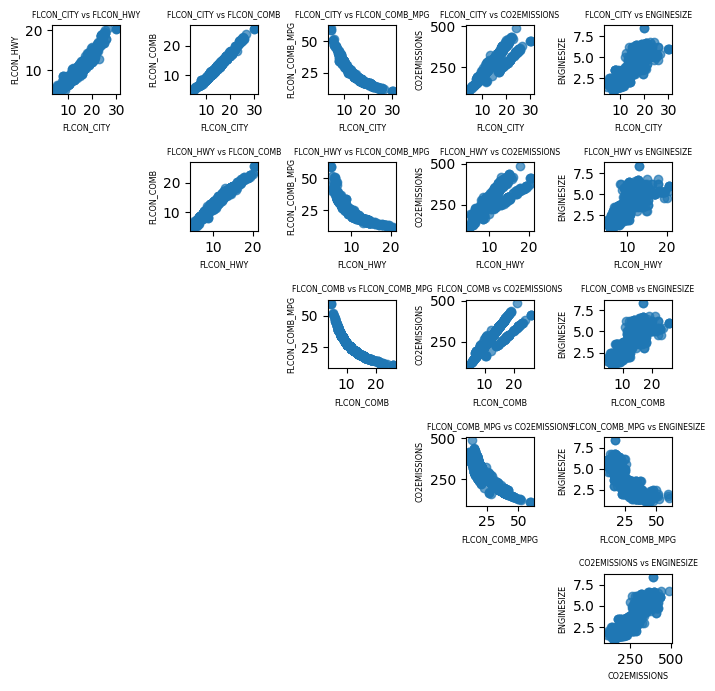

In [5]:
df_new = df[['FLCON_CITY','FLCON_HWY','FLCON_COMB', 'FLCON_COMB_MPG', 'CO2EMISSIONS','ENGINESIZE']]
plots = []
colspace = df_new.columns

fig, axes = plt.subplots(nrows=len(colspace), ncols=len(colspace), figsize=(8, 8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
        
for i in range(len(colspace)):
    for j in range(len(colspace)):
        ax = axes[i, j]
        if j > i:
            x_col = colspace[i]
            y_col = colspace[j]
            ax.scatter(df_new[x_col], df_new[y_col], alpha=0.7)
            ax.set_xlabel(x_col, fontsize=5.8)
            ax.set_ylabel(y_col, fontsize=5.8)
            ax.set_title(f'{x_col} vs {y_col}', fontsize=5.6)
            plots.append(ax)
        else:
            ax.set_visible(False)
plt.tight_layout()
plt.show()

We immediately notice which variables have a linear relationship and which variables don't.

- FLCON_CITY vs FLCON_HWY: very linear
- FLCON_CITY vs ENGINESIZE: roughly linear but higher variance
- FLCON_CITY vs FLCON_COMB_MPG: roughly nonlinear


This leads us to hypothesise that a linear regression model would be suitable to model the first two relationships. The third may not admit such an approximation. We will nevertheless conduct linear regression all three to a) determine a reliable set of coefficients for the first relationship and b) to investigate the decline in model accuracy as linearity is reduced.  

In [6]:
X_var = 'FLCON_CITY'
y_vars = ['FLCON_HWY', 'ENGINESIZE', 'FLCON_COMB_MPG']

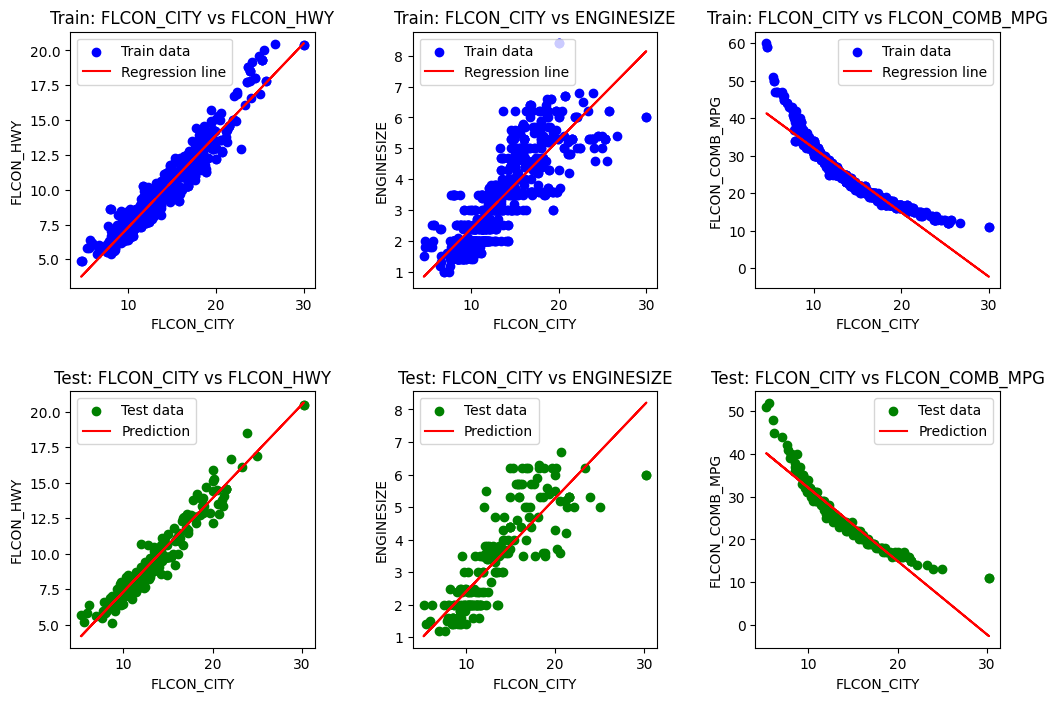

           Target  Coefficient  Intercept   MAE   MSE  RMSE  R2 Score
0       FLCON_HWY         0.66       0.71  0.52  0.48  0.69      0.94
1      ENGINESIZE         0.29      -0.49  0.65  0.68  0.82      0.68
2  FLCON_COMB_MPG        -1.72      49.24  1.84  7.39  2.72      0.87


In [7]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Create and fill plots
results = []
fig, axes = plt.subplots(2, len(y_vars), figsize=(12, 8)) 
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i, y_var in enumerate(y_vars):
    X = df[X_var].to_numpy()
    y = df[y_var].to_numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    X_train_reshaped = X_train.reshape(-1, 1)
    X_test_reshaped = X_test.reshape(-1, 1)

    regressor = linear_model.LinearRegression()
    regressor.fit(X_train_reshaped, y_train)
    predictions = regressor.predict(X_test_reshaped)

    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    coef = regressor.coef_[0]
    intercept = regressor.intercept_

    results.append({
        'Target': y_var,
        'Coefficient': round(coef, 2),
        'Intercept': round(intercept, 2),
        'MAE': round(mae, 2),
        'MSE': round(mse, 2),
        'RMSE': round(rmse, 2),
        'R2 Score': round(r2, 2)
    })

    ax_train = axes[0, i]
    ax_train.scatter(X_train, y_train, color='blue', label='Train data')
    ax_train.plot(X_train, regressor.predict(X_train_reshaped), color='red', label='Regression line')
    ax_train.set_title(f'Train: {X_var} vs {y_var}')
    ax_train.set_xlabel(X_var)
    ax_train.set_ylabel(y_var)
    ax_train.legend()

    ax_test = axes[1, i]
    ax_test.scatter(X_test, y_test, color='green', label='Test data')
    ax_test.plot(X_test, predictions, color='red', label='Prediction')
    ax_test.set_title(f'Test: {X_var} vs {y_var}')
    ax_test.set_xlabel(X_var)
    ax_test.set_ylabel(y_var)
    ax_test.legend()

plt.savefig("../images/lin-reg.png", dpi=300, bbox_inches='tight')
plt.show()
print(pd.DataFrame(results))

The scatterplots and associated regression lines illustrate the linear relationship between `FLCON_CITY` (x-axis) and each target variable (y-axis). As expected, the relationship between `FLCON_CIty` and `FLCON_HWY` is nearly linear and tight, yielding a high R² value and low RMSEs, confirming our earlier assumptions. It stands to reason that the higher the fuel consumption of a car in the city, the higher it will be on the highway too as both are governed by underlying engine characteristics and vehicle efficiency, albeit under different driving conditions. The outliers in the data can be explained by cars that got stuck in traffic in busy urban zones. The scale of the axes also reflects the disparity in fuel consumption in the city and on highways.

Interestingly, we see that despite `FLCON_CITY` vs `FLCON_COMB_MPG` following a non-linear pattern, the regression is still a strong fit. This is perhaps 
unsurprising, given that `FLCON_COMB_MPG` is a weighted combination of city and highway consumption. The high explanatory power here serves as a sanity check on the internal consistency of the dataset. The error terms, however, are the largest in the dataset. This is shown by the disportio at the left tail. Why is this? This can be explained by the fact that `FLCON_COMB_MPG` is the combination of `FLCON_CITY` and `FLCON_HWY` expressed in **MPG**, and the functional relationship between **MPG** and L/100km is **convex**:

$$ MPG = \frac{k}{(L/100km)}$$ 

Thus, the smaller the value of `FLCON_CITY` the larger `FLCON_COMB_MPG` becomes (since, remember, `FLCON_HWY` tends to decrease as `FLCON_CIY` does), and this increase is non linear, which is why we see the left tail of the plot veer sharply upwards from the regression line - this aspect is not captured by the linear regression and is the main source of error in the model. The fact that the error is mostly at the tails is captued by the fact that the MAE is $<3$ times as large as the other models', but the MSE, which is biased towards outliers, is an order of magnitude larger.

In contrast, we see that`ENGINESIZE` and `FLCON_CITY` are correlated, but there is a lot that the model does not explain; the error here can be explained by the lack of key features informing the relationship such as weight, aerodynamics, drivetrain efficiency, torque, etc — and thus explains less of the variance in `FLCON_CITY`.

This comparison highlights that even visually non-linear trends can be statistically more predictable than seemingly linear ones if the underlying relationship is deterministic or derived, as is the case with MPG.

